# Module 7: Numerical Statistics
## Medical Signal Processing and Statistics (E010390)
### Dept of Information Technology (UGent) and Dept of Electronics and Informatics (VUB)
Sarah Verhulst

<font color=blue>Students names and IDs: </font> <Br>
<font color=blue>Academic Year </font>: 2022-2023

In [1]:
import numpy as np                # this need's no expl
from scipy import signal          #
from scipy import fftpack as fft
import math as math
import matplotlib.pyplot as plt
from scipy import stats
# import itertools                  # used to iterate over all combinations of parameters for a certain plot
# alternative: plotly - also for jupyterLab

## If you get an error on startup - in the command window, please install the following package
#pip install ipympl

## WAV files
from scipy.io import wavfile
import warnings                   # used to ignore some warnings in WAV-file reading
warnings.simplefilter(action='ignore', category=wavfile.WavFileWarning)

## HTML/CSS styling
from IPython.display import HTML
def css_styling():
    return HTML(open("../assets/styles/custom.css",'r').read())

## Plot parameters
#plt.ioff()                        # interactive mode off -- this means you need plt.show() to show the plots
#plt.rcParams['figure.figsize'] = [12, 8]
#plt.rcParams.update({'font.size': 22})

from pylab import *
from scipy.signal import firwin, lfilter, filtfilt
from scipy.io import loadmat
import scipy as sci
import scipy.io
import scipy.signal as sig
from scipy import stats
import statsmodels

$
\newcommand{\fsamp}{{F_s}}
\newcommand{\tsamp}{{T_s}}
\newcommand{\unit}[1]{\ensuremath{\text{#1}}}
\newcommand{\tmidx}{n}
\newcommand{\tds}[2][\tmidx]{{#2(#1)}}
\newcommand{\matcmd}[2][(\cdot)]{\texttt{#2}#1}
\renewcommand{\matcmd}[2][(\cdot)]{\mathrm{#2}#1}
\newcommand{\fcn}[1]{{\text{#1}}}
\newcommand{\bigcb}[1]{{\big\{#1\big\}}} 
\newcommand{\Bigcb}[1]{{\Big\{#1\Big\}}}
\newcommand{\bigsb}[1]{{\big[#1\big]}} 
\newcommand{\Bigsb}[1]{{\Big[#1\Big]}}
\newcommand{\biggsb}[1]{{\bigg[#1\bigg]}}
\newcommand{\pyt}{\matcmd[]{Python}}
\newcommand{\fds}[2][z]{#2(#1)}
\newcommand{\zpow}[1][-1]{z^{#1}}
\newcommand{\cbr}[1]{\big\{#1\big\}}
\newcommand{\mat}[1]{\boldsymbol{#1}}
$

## General info
In this exercise, we will further explore bootstrapping techniques to evaluate the quality of correlation/linear regression analysis on collected datapoints, as well as perform hypothesis testing on event-related brain signals. Both of these techniques will come handy in your future biomedical data-science projects. You will also be pointed to tools/packages which can come in handy to visualize or better understand your collected data.

## Exercise 1: Regression statistics 
When we have a data-array of two variables, it is possible to make a scatter-plot of the data (i.e. plot the x variables against the y-variables), and study whether the variables are linearly related. Using a correlation analysis (`sci.stats.pearsonr` or `sci.stats.spearmanr`) we can get an estimate of the strength of the relationship between the two variables, and if we apply a linear regression model (`sci.stats.linregress`), we can find the slope and intercept parameters of the best linear fit: y = slope * x + intercept to the data. 

Regression models are often applied to collected data-sets to infer whether one variable predicts the other, or whether there is a causal relationship between two variables. In this respect it is important to consider the certainty with which you can draw your conclusion from the collected data, and a leave-one-out bootstrap procedure can come in handy here. First, have a look at plotting the following data-set:

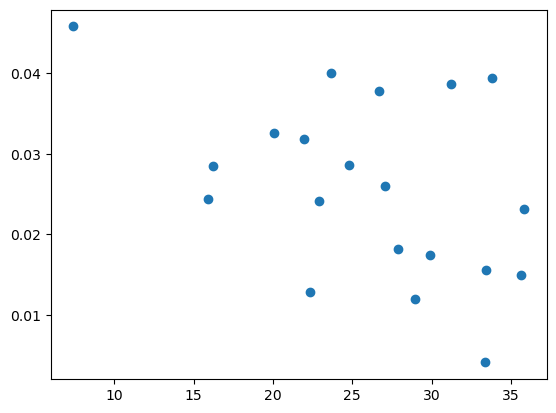

In [2]:
DPTH = np.array([35.84, 20.09, 22.34, 31.24, 16.20, 29.91, 24.79, 15.91, 7.40, 27.05, 33.80, 26.71, 21.96, 33.36, 22.89,
        23.66, 33.42, 35.66, 27.88, 28.97])
EFR = np.array([0.02309, 0.03251, 0.01280, 0.03868, 0.02843, 0.01743, 0.02855, 0.02433, 0.04578, 0.02599, 0.03936, 0.03773,
       0.03184, 0.00411, 0.02412, 0.03997, 0.01557, 0.01502, 0.01815, 0.01199])
EFRstd = np.array([0.00564, 0.00644, 0.00881, 0.00473, 0.0067, 0.00982, 0.00777, 0.00689, 0.00594, 0.00565, 0.01148, 0.00832,
          0.00574, 0.01074, 0.01473, 0.00958, 0.01045, 0.00775, 0.01162, 0.00577])
plt.figure()
plt.plot(DPTH,EFR,'o')
#unit of DPTH [dB SPL]
#unit of EFR [\muV]

Some background about the data you are working with. Both variables are objective measures of hearing function recorded from the same individual i.e. each datapoint resembles two measures taken from the same person. 

* Envelope-following-responses (EFRs) are auditory evoked potentials which are recorded using an EEG setup in response to sound stimulation with an amplitude-modulated pure-tone. The ensemble auditory-nerve and brainstem neurons are very capable of tracking the stimulus envelope, and the EEG recording will hence show a peak at the auditory envelope frequency. Animal studies have demonstrated that the strenght of this peak in an individual might inform about the total number of auditory-nerve fibers an individual has available. When there is hearing damage, this number will be lower.

* The second variable is the distortion-product otoacoustic emission threshold (DPOAE TH). This is a marker of hearing which is often used in clinical practice to assess whether the outer-hair-cells are intact. The lower the DPOAE threshold (the minimal sound level at which a measureable DPOAE is recorded), the more sensitive your hearing is. People with damaged outer-hair-cells generally have higher DPOAE thresholds (DPTH). 

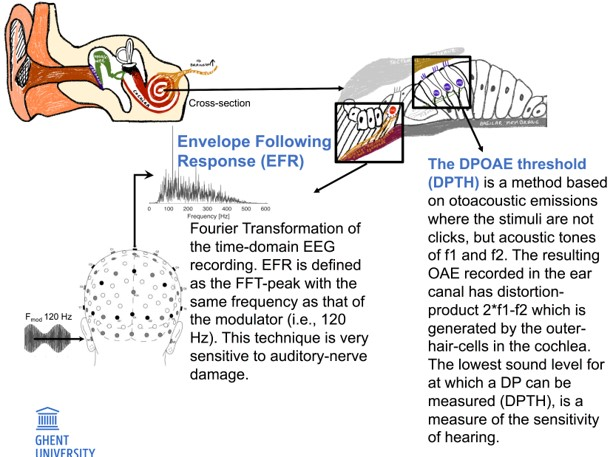

Given this scatter-plot, you could fit a single regression line and make a conclusion about the causal relationship between the two variables. However, you can clearly see that there is an outlier. If you would leave it in, the relationship between the two variables might be stronger, if you remove it, there might not be a relationship left. You found no other reasons to discard this datapoint (i.e. the data collection quality was good). 

<div class="alert alert-info">

**Task**
    
To analyse the variability of your regression model, you can apply a leave-one-out bootstrap procedure. In this procedure, you remove a single data-point from the set and calculate the regression statistics as you would do for the complete dataset. This will yield N regression curves, p-values and r-values which that you can use to study the robustness of your linear regression model. That is, you can plot distributions (histograms) of your p/r-values to assess whether the variability is reasonable.
    
* First, apply this method on your dataset (x-variable: DPTH and y-variable: EFR) by running `sci.stats.linregress` function in a for loop (look up its use online), and plot the regression curves belonging to the individual leave-one-out iterations on top of the scatter-plot. Also include the reference regression model curve that you obtained when including all data-points. 

* Second, perform the same analysis after dropping the outlier value from the dataset using `np.delete`. 
    
* Compare the robustness of the two regression models to address the following questions: What is the effect of the one aparent outlier on the interpretation of the relationship? Does the dataset allow you to infer that you can use the EFR and DPOAE interchangeably in a hearing screening procedure?

In [3]:
# DPTH
# array([35.84, 20.09, 22.34, 31.24, 16.2 , 29.91, 24.79, 15.91,  7.4 ,
#        27.05, 33.8 , 26.71, 21.96, 33.36, 22.89, 23.66, 33.42, 35.66,
#        27.88, 28.97])

# EFR
# array([0.02309, 0.03251, 0.0128 , 0.03868, 0.02843, 0.01743, 0.02855,
#        0.02433, 0.04578, 0.02599, 0.03936, 0.03773, 0.03184, 0.00411,
#        0.02412, 0.03997, 0.01557, 0.01502, 0.01815, 0.01199])

# x = DPTH
# np.delete(x, 1)
# array([35.84, 22.34, 31.24, 16.2 , 29.91, 24.79, 15.91,  7.4 , 27.05,
#        33.8 , 26.71, 21.96, 33.36, 22.89, 23.66, 33.42, 35.66, 27.88,
#        28.97])

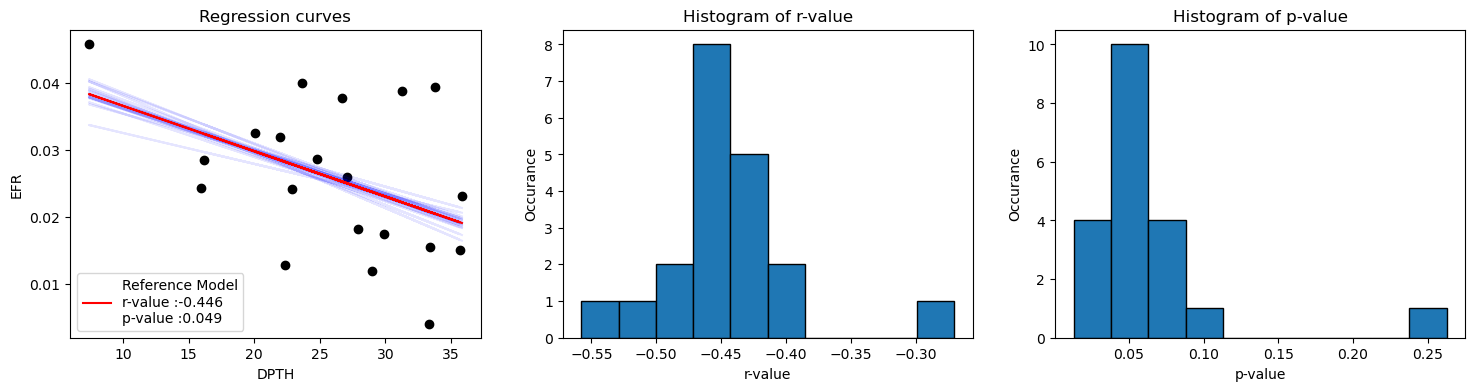

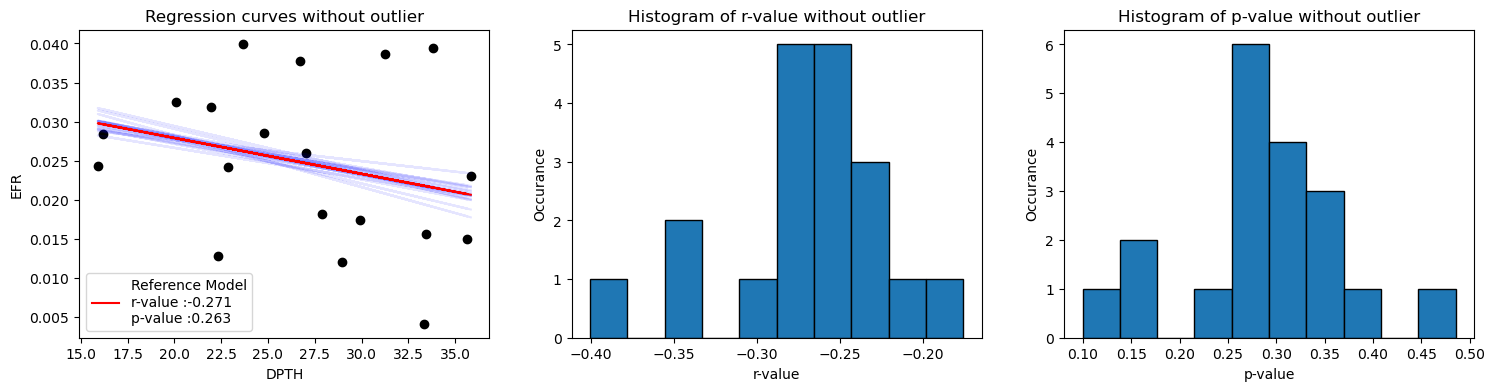

In [4]:
x = DPTH  # 20 data
y = EFR  # 20 data

# Calculate the leave-one-out regression slopes and intercepts
n = len(x) # n = 20
slopes = []
intercepts = []
rvals = []
pvals = []
for i in range(n):
    x_rem = np.delete(x, i)
    y_rem = np.delete(y, i)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_rem, y_rem)
    slopes.append(slope)
    intercepts.append(intercept)
    rvals.append(r_value)
    pvals.append(p_value)
slopes = np.array(slopes)
intercepts = np.array(intercepts)

# Calculate the reference regression model
reg = stats.linregress(DPTH, EFR)

# Plot the scatter plot and regression lines
fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(131)
plt.scatter(DPTH, EFR, color='black')
plt.title("Regression curves")
for i in range(len(DPTH)):
    plt.plot(DPTH, slopes[i] * DPTH + intercepts[i], color='blue', alpha=0.1)
plt.plot(DPTH, reg.slope * DPTH + reg.intercept, color='red', 
         label='Reference Model'+f'\nr-value :{round(reg.rvalue,3)}'+f'\np-value :{round(reg.pvalue,3)}')
plt.legend()
plt.xlabel('DPTH')
plt.ylabel('EFR')

# histogra
ax = fig.add_subplot(132)
plt.hist(rvals, edgecolor='black')
plt.title('Histogram of r-value')
plt.xlabel('r-value')
plt.ylabel('Occurance')

ax = fig.add_subplot(133)
plt.hist(pvals, edgecolor='black')
plt.title('Histogram of p-value')
plt.xlabel('p-value')
plt.ylabel('Occurance')
plt.show()

# print("To make sure what outlier")
# print ("outlier value of p-value : " +f"{sorted(pvals, reverse = True)[0]}")
# print("outlier value of r-value : " + f"{sorted(rvals, reverse = True)[0]}")
# To make sure what outlier
# outlier value of p-value : 0.2626177620858644
# outlier value of r-value : -0.27053436376771817

# Second 
# dropping the outlier 
outp_index = np.where(pvals == np.max(pvals))
outr_index = np.where(rvals == np.max(rvals))
# print(outp_index)-> 8
# print(outr_index)-> 8
DPTH_pop = np.delete(DPTH, outp_index)
EFR_pop = np.delete(EFR, outp_index)

n = len(DPTH_pop) # n = 20
slopes = []
intercepts = []
rvals = []
pvals = []
for i in range(n):
    x_rem = np.delete(DPTH_pop, i)
    y_rem = np.delete(EFR_pop, i)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_rem, y_rem)
    slopes.append(slope)
    intercepts.append(intercept)
    rvals.append(r_value)
    pvals.append(p_value)
slopes = np.array(slopes)
intercepts = np.array(intercepts)

# Calculate the reference regression model
reg = stats.linregress(DPTH_pop, EFR_pop)

# Plot the scatter plot and regression lines
fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(131)
plt.scatter(DPTH_pop, EFR_pop, color='black')
plt.title("Regression curves without outlier")
for i in range(len(DPTH_pop)):
    plt.plot(DPTH_pop, slopes[i] * DPTH_pop + intercepts[i], color='blue', alpha=0.1)
plt.plot(DPTH_pop, reg.slope * DPTH_pop + reg.intercept, color='red', 
         label='Reference Model'+f'\nr-value :{round(reg.rvalue,3)}'+f'\np-value :{round(reg.pvalue,3)}')
plt.legend()
plt.xlabel('DPTH')
plt.ylabel('EFR')

# histogra
ax = fig.add_subplot(132)
plt.hist(rvals, edgecolor='black')
plt.title('Histogram of r-value without outlier')
plt.xlabel('r-value')
plt.ylabel('Occurance')

ax = fig.add_subplot(133)
plt.hist(pvals, edgecolor='black')
plt.title('Histogram of p-value without outlier')
plt.xlabel('p-value')
plt.ylabel('Occurance')
plt.show()

\tcbset{ frame code={} center title, left=0pt, right=0pt, top=0pt, bottom=0pt, colback=green!50, colframe=white, width=\dimexpr\textwidth\relax, enlarge left by=0mm, boxsep=5pt, arc=0pt,outer arc=0pt, }
<div class="alert alert-success">
<span style="color:black">
\begin{tcolorbox}
  
Compare the robustness of the two regression models to address the following questions: What is the effect of the one aparent outlier on the interpretation of the relationship? Does the dataset allow you to infer that you can use the EFR and DPOAE interchangeably in a hearing screening procedure?

First of all, the yeilded r-value(correlation coefficient) represents the strength of the linear relationship between the EFR and DPTH, while the obtained p-value represents whether the correlation between the two variables is statistically significant or not.

 As you can see the two graphs of regression curves shown above, there is a negative correlation between the two variables. Nonetheless, after removing the outlier(the second method), the value of the r-value increased from -0.446 to -0.271, which tells us that the negative strength of the linear relationship between these two values became weaker. What is more, the p-value increased after the second method from 0.049 to 0.263 (i.e,in this context the correlation between the two variables is not statisitically significant)
 
 Therefore, the presence of the one aparent outlier has a significant influence on the result. Keeping the outlier(The first method) suggests it has a strong influence on the correlation, while removing the outlier(The second method) suggests the correlation may be weaker and not significant without it.

 Since the two regression models give you only the strongth and significance of the correlation between the two valuables, it might be difficult to say that the dataset allows you to infer that you can use the EFR and DPOAE interchangeably. 
    
\end{tcolorbox}
    
</span>

## Exercise 2: Hypothesis testing using event-related-potentials
Here, we will make use of that event-related potentials (EEG to a sensory event) often use multiple repetitions to the same stimulus to improve the signal-to-noise ratio of the data (see Module 6). We will use this information to perform bootstrapping-based hypothesis testing. For the specific example at hand, we have about 5000 repetitions of an acoustic click, to which we recorded the EEG signal (auditory brainstem response, ABR). The resulting signal has a very typical waveform with distict peaks that occur within the first 10 ms after the click onset, and which resemble different processing stages along the auditory pathway. The peak at 1-2 ms (wave-I) reflects the ensemble of auditory-nerve fibers available, whereas the peak at 5-7 ms (wave-V) reflects the brainstem processing of sound (inferior colliculus). The ABR is hence some sort of impulse response of the ear, and is often clinically used to detect peripheral brain lesions, or as a screening tool for neonates. The signal also has information about how the ear processes sound (i.e. for research purposes), and in this example, we would like to assess the following: 

* Is the wave-V amplitude significantly higher for an ABR to a 100 dB stimulus than for the ABR to a 80 dB stimulus level?
* Is the wave-V latency (i.e. the time [in ms] at which the peak of wave-V occurs) significantly shorter for the 100 dB stimulus than for the 80 dB stimulus?

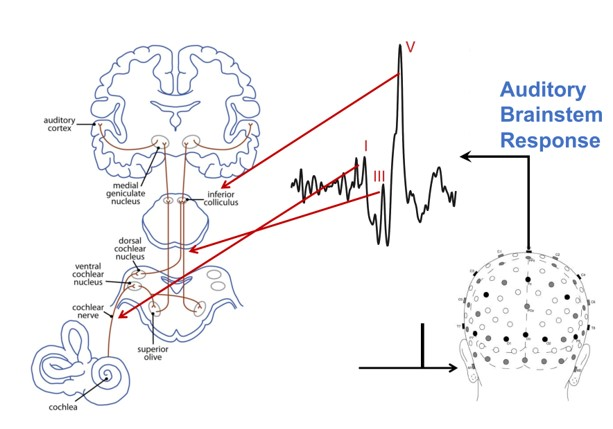

Work through the different steps to preprocess your data, start with the 100-dB ABR to go through all preprocessing steps, and then repeat the same steps for the 80-dB ABR. Afterwards, you can compare the EEG response features statistically and formulated a motivated answer to the above questions. 
First, we will perform the filtering, epoching and averaging such that we can visualise the evoked potentials, calculate their confidence intervals and perform the statistical assessment.   

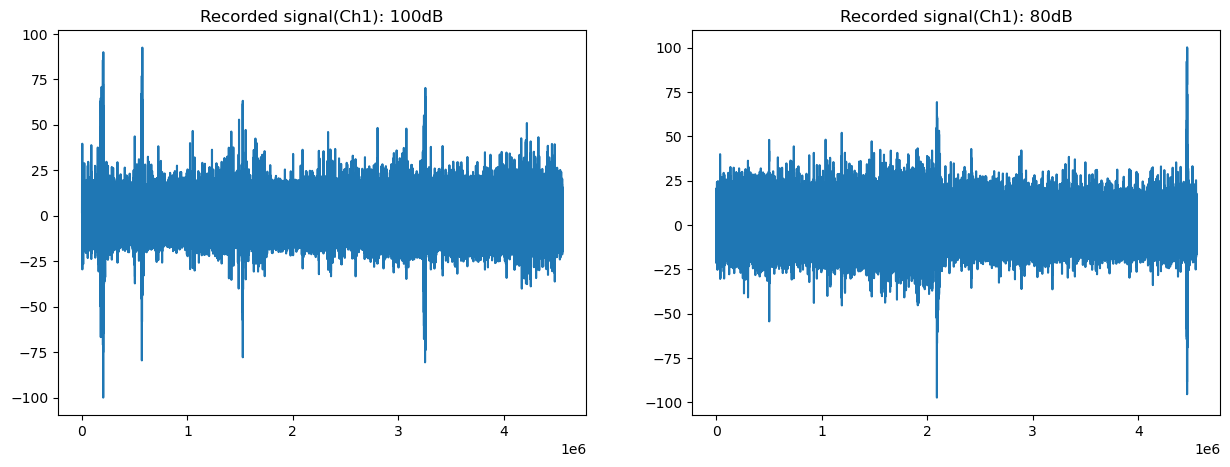

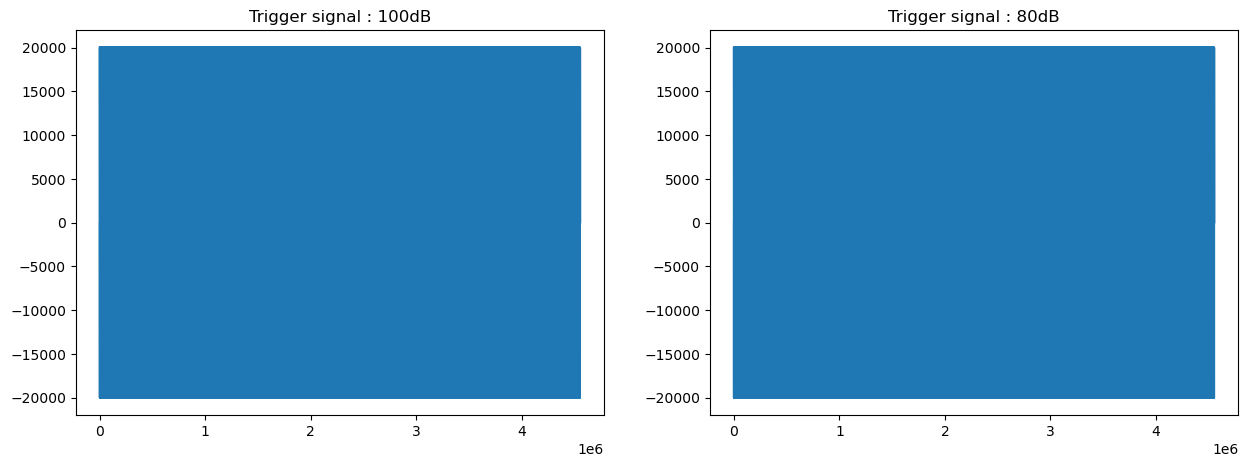

In [5]:
###################################################################
# 100dB
#Load in the data
ABRData100 = scipy.io.loadmat('ABR100dB.mat')
#automatic filtering is already applied between 10 and 1500 Hz as part of the recording software, 
#but we will at least apply a HP filter with higher cut-off frequency to remove low-frequency and 50-Hz noise.

#here we do all the analysis for the 100dB stimulus, you should do the same for the 80 dB stimulus.
Sig_100=ABRData100['DATA'] #has the raw recording trace of EEG data (i.e. 5 min recording)
FS=10000;
Ch1_100=Sig_100[0,:] #is the recording channel we will work with
T_100=Sig_100[2,:] #is the channel with equal duration of the recording, but which has the trigger events 
#(i.e. sample numbers at which a click was presented)
#find all the triggers
indxP_100 = np.where(T_100 == 20001)[0]
indxN_100 = np.where(T_100 == -20001)[0]
indx_100 = np.concatenate((indxP_100,indxN_100),axis=0) #index has the sample numbers at which an event started, and is necessary to epoch the data.

###################################################################
# 80dB
#Load in the data
ABRData80 = scipy.io.loadmat('ABR80dB.mat')
Sig_80=ABRData80['DATA']
FS=10e3;
Ch1_80=Sig_80[0,:]
T_80=Sig_80[2,:]

#find all the triggers
indxP_80 = np.where(T_80 == 20001)[0]
indxN_80 = np.where(T_80 == -20001)[0]
indx_80 = np.concatenate((indxP_80,indxN_80),axis=0)
# print(np.shape(T_80[indx_80])) (5007,)
# print(indx_80)[      0    1818    3636 ... 4545909 4547727 4549545]


fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(121)
#Get a feeling for your data
plt.plot(Ch1_100)
plt.title('Recorded signal(Ch1): 100dB')

ax = fig.add_subplot(122)
#Get a feeling for your data
plt.plot(Ch1_80)
plt.title('Recorded signal(Ch1): 80dB')

fig = plt.figure(figsize = (15,5))
ax=fig.add_subplot(121)
plt.plot(T_100)
plt.title('Trigger signal : 100dB')
# plt.xlim((10000,20000))

ax=fig.add_subplot(122)
plt.plot(T_80)
plt.title('Trigger signal : 80dB')
# plt.xlim((10000,20000))
plt.show()
#Note that the trigger mark either positive or negative polarities of the stimulus click (0 to 100 dB or -100 to dB). 
#This is not relevant here as we will just average both polarities together, but those interested could also repeat 
#the analysis for only the positive or negative polarity click stimuli. 

In [6]:
# Sig #(3, 4554599)
# array([[ 2.00805664e+00,  2.53601074e+00,  3.33557129e+00, ...,
#          1.02539062e+00, -2.65502930e-01, -6.98852539e-01],
#        [-8.51440430e-01,  4.45556641e-01,  1.34582520e+00, ...,
#          9.25598145e+00,  1.01165771e+01,  1.08245850e+01],
#        [ 2.00010000e+04,  0.00000000e+00,  0.00000000e+00, ...,
#          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

# Ch1 # (4554599,)
# array([ 2.00805664,  2.53601074,  3.33557129, ...,  1.02539062,
#        -0.26550293, -0.69885254])

<div class="alert alert-info">

**Task**
    
* Apply an 8th order butterworth filter (`sig.butter`) to your data (Ch1) with cut-off frequencies between 100 and 1500 Hz. Use a zero-phase design to perform the filtering (see modules 5,6). Apply first the HP filter and then afterwards the LP filter. Plot the magnitude spectrum of the original signal and the filtered signal to check whether your filter worked. What do you think the spectral peaks are (Hint: check their frequencies)?

\tcbset{ frame code={} center title, left=0pt, right=0pt, top=0pt, bottom=0pt, colback=green!50, colframe=white, width=\dimexpr\textwidth\relax, enlarge left by=0mm, boxsep=5pt, arc=0pt,outer arc=0pt, }
<div class="alert alert-success">
<span style="color:black">
\begin{tcolorbox}

What do you think the spectral peaks are (Hint: check their frequencies)?

The peaks you can see in the orignal signals at lower 100Hz are filtered out, and you can identify peaks only between 100Hz and 1500Hz. 

\end{tcolorbox}
    
</span>

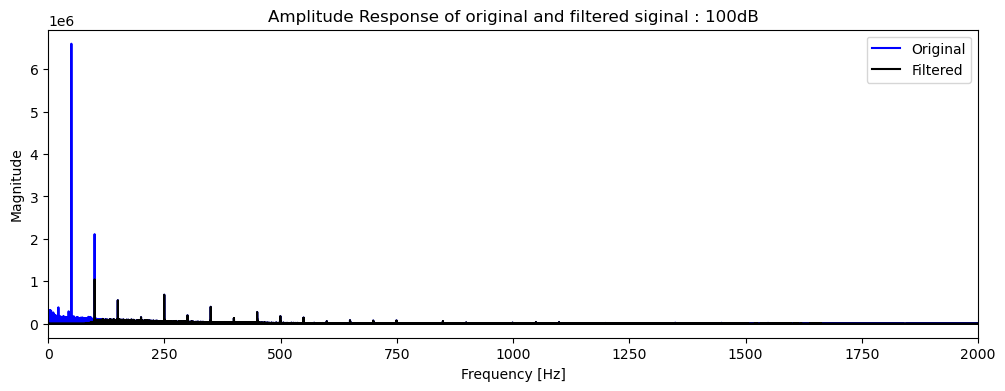

In [7]:
#your code goes here
N = 8  # 8th order butterworth filter
Wn_LPF = 1500
Wn_HPF = 100
## LPF (Frequency response)##
LPF = signal.butter(N, Wn_LPF, btype='low', analog=False, output='ba', fs=FS)
B_LPF  = LPF[0]
A_LPF  = LPF[1]
w, h = signal.freqz(B_LPF,A_LPF,fs=FS)
Freq = np.linspace(0,1,len(w))
Amp, phase = 20*np.log10(np.abs(h)), np.angle(h) 

## HPF (Frequency response)##
HPF = signal.butter(N, Wn_HPF, btype='highpass', analog=False, output='ba', fs=FS)
B_HPF  = HPF[0]
A_HPF  = HPF[1]
w, h = signal.freqz(B_HPF,A_HPF,fs=FS)
Freq = np.linspace(0,1,len(w))
Amp, phase = 20*np.log10(np.abs(h)), np.angle(h) 

### 0 - phase filtering ###
### First HPF -> LPF
#### Remove frequency of less than 100Hz
output = signal.filtfilt(B_HPF,A_HPF,Ch1_100)
#### Remove frequency of more than 1500Hz
filtred_Ch1_100 = signal.filtfilt(B_LPF,A_LPF,output) # work with 

#### Filtered Ch1 FFT
fft_filtered_Ch1_100 = np.fft.fft(filtred_Ch1_100)
filteredCh1_freq_100 = np.fft.fftfreq(Ch1_100.size, 1/FS)
Amp_filtered_Ch1_100 = np.abs(fft_filtered_Ch1_100)

#### Fon-filtered Ch1 FFT
fft_Ch1_100 = np.fft.fft(Ch1_100)
Ch1_freq_100 = np.fft.fftfreq(Ch1_100.size, 1/FS)
Amp_Ch1_100 = np.abs(fft_Ch1_100)

# Amplitude response 
fig = plt.figure(figsize=(12,4));
ax = fig.add_subplot(111)
plt.plot(Ch1_freq_100, Amp_Ch1_100,color = "b")
plt.plot(filteredCh1_freq_100, Amp_filtered_Ch1_100,color = "k")
plt.title('Amplitude Response of original and filtered siginal : 100dB')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim((0,2000))
plt.legend(["Original","Filtered"])

plt.show()

"""
for the next task
"""

output = signal.filtfilt(B_HPF,A_HPF,Ch1_80)
filtred_Ch1_80 = signal.filtfilt(B_LPF,A_LPF,output)

After filtering, it is time to epoch your data into different trials such that you can perform an averaging across trials. The sample numbers at which a stimulus was presented, are given by the indx array. When epoching for this type of data, it is important to cut your signal 5 ms before the trigger (indx events) and analyse up to 20 ms after the trigger event. 

<div class="alert alert-info">

**Task**
    
* Count the number of events (stimulus clicks), and make a matrix with has dimensions (`len(indx)` x samples). The samples you should include correspond in each epoch correspond to a time start 5 ms before the click and runs 20 ms until after the click. Make a corresponding time axis, that has time 0 correspond to the time of the click. Make a figure that plots time vs all your epochs at once (you might have to transpose your matrix to plot using the `.T` expression). 
    
* This visualisation is helpful when determining a threshold above which you will remove 
"bad" or "noisy" epochs. Here, you will likely only remove 5 or 10 % of the noisiest epochs (the ones with the largest absolute amplitude). Write a code to automatically remove epochs with amplitudes above a reasonable "self-determined" threshold value. Discard the noisy epochs and now compare your epochs before and after noise-rejecting. Did your algorithm work?
    
* Once you have rejected the noisy epochs, you can average the remaining epochs to obtain the mean ABR waveform (plotted over time). Do you notice the wave-V peak near 6-7 ms?
    
* Perform the same preprocessing steps for the 80 dB ABR data.

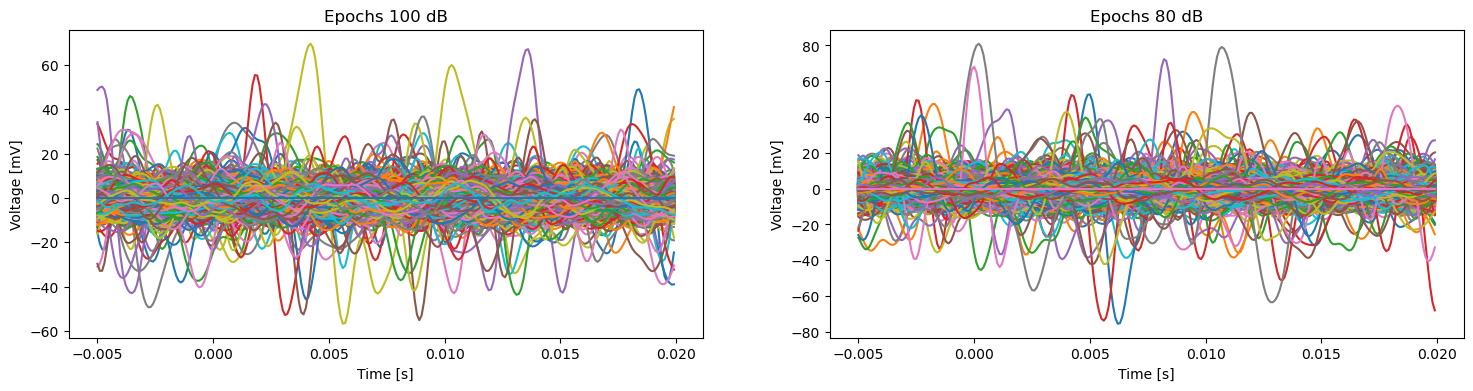

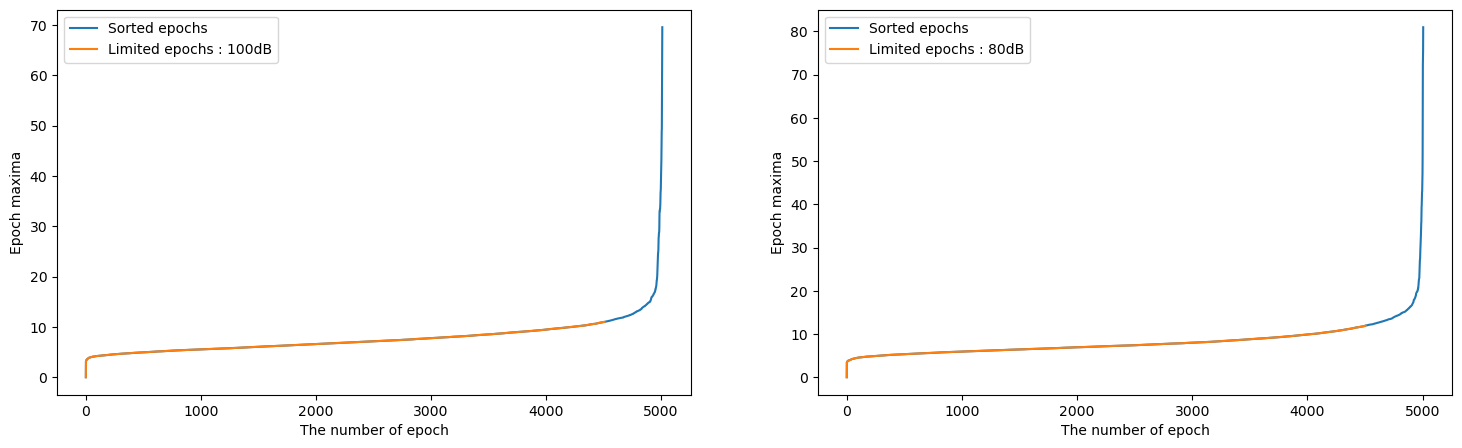

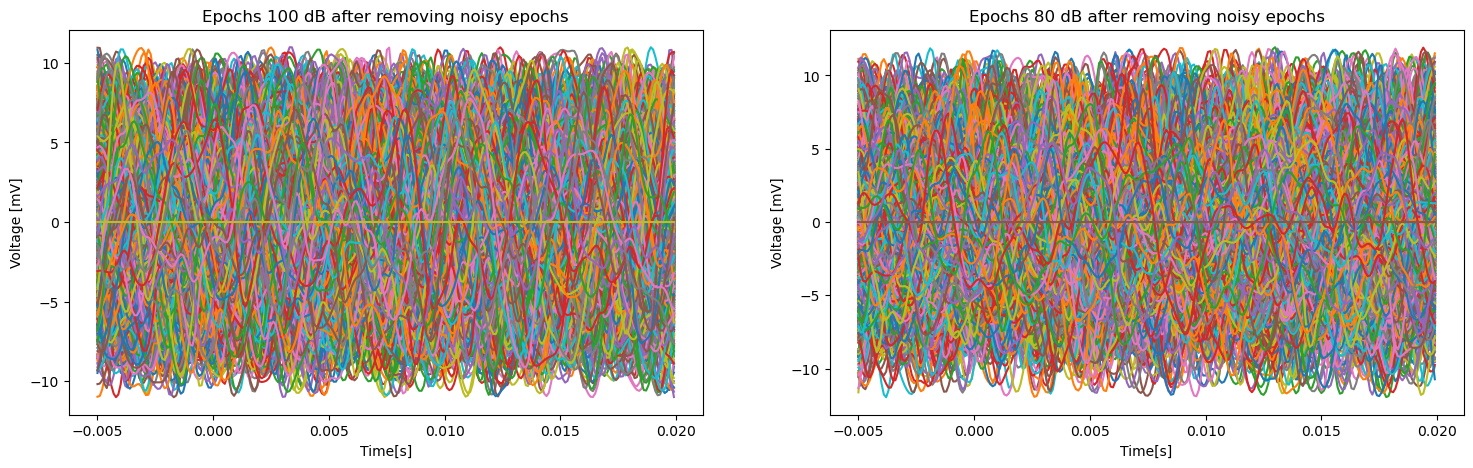

In [8]:
#your code goes here
# count the number of events(stimulus clicks)
#len(indx) # 5011 # This is the samples number = 5011
t = np.arange(-0.005, 0.020, 1/FS) # 250
epochs100 = np.zeros((len(indx_100), len(t)))
epochs80 = np.zeros((len(indx_80), len(t)))
ms_5 = int(FS*0.005)
ms_20 = int(FS*0.020)

###############################################################################################
# 100dB
max_100 = []
for i, click in enumerate(indx_100[1:]): 
    epochs100[i] = filtred_Ch1_100[ click - ms_5 : click + ms_20]
    max_100.append(np.max(np.abs(filtred_Ch1_100[click-int(0.005*FS):click+int(0.020*FS)])))
    

max_80 = []
for i, click in enumerate(indx_80[1:]): 
    epochs80[i] = filtred_Ch1_80[ click - ms_5 : click + ms_20]
    max_80.append(np.max(np.abs(filtred_Ch1_80[click-int(0.005*FS):click+int(0.020*FS)])))

fig = plt.figure(figsize = (18,4))
ax = fig.add_subplot(121)
for i in range(len(indx_100)):
    plt.plot(t,epochs100[i])
    plt.title('Epochs 100 dB')
    plt.xlabel('Time [s]')
    plt.ylabel('Voltage [mV]')
    
ax = fig.add_subplot(122)
for i in range(len(indx_80)):
    plt.plot(t,epochs80[i])
    plt.title('Epochs 80 dB')
    plt.xlabel('Time [s]')
    plt.ylabel('Voltage [mV]')
    
plt.show() 
   
# remove noisy epochs
maxs_100 = []
for i in range(len(indx_100)):
    max = np.max(np.abs(epochs100[i]))
    maxs_100.append(max)

indices_100 = np.argsort(maxs_100)
sorted_maxs_100 = np.sort(maxs_100)

num_100 = int(len(indx_100) * 0.90)# 10%
limit_100 = sorted_maxs_100[0:num_100]

maxs_80 = []
for i in range(len(indx_80)):
    max_80 = np.max(np.abs(epochs80[i]))
    maxs_80.append(max_80)

indices_80 = np.argsort(maxs_80)
sorted_maxs_80 = np.sort(maxs_80)

num_80 = int(len(indx_80) * 0.90)# 10%
limit_80 = sorted_maxs_80[0:num_80]

# Limitation of epochs
fig = plt.figure(figsize = (18,5));fig.clf()
ax = fig.add_subplot(121)
plt.plot(sorted_maxs_100)
plt.plot(limit_100)
plt.xlabel("The number of epoch")
plt.ylabel("Epoch maxima")
plt.legend(["Sorted epochs","Limited epochs : 100dB"])

ax = fig.add_subplot(122)
plt.plot(sorted_maxs_80)
plt.plot(limit_80)
plt.xlabel("The number of epoch")
plt.ylabel("Epoch maxima")
plt.legend(["Sorted epochs","Limited epochs : 80dB"])

# Observe between before removed and afteer removed

# Firstly removing 
removed_indices_100 = indices_100[num_100:len(indx_100)] #from 4760th index to 5011th index are deleted from the original epochs set
index_l_100 = removed_indices_100.tolist()
removed_epochs100 = np.delete(epochs100,index_l_100,0)

removed_indices_80 = indices_80[num_80:len(indx_80)] 
index_l_80 = removed_indices_80.tolist()
removed_epochs80 = np.delete(epochs80,index_l_80,0)

# print(len(removed_indices))
fig = plt.figure(figsize = (18,5))
ax = fig.add_subplot(121)   
plt.title("Epochs 100 dB after removing noisy epochs")
for i in range(len(indx_100)-len(removed_indices_100)):
    plt.plot(t,removed_epochs100[i])
    plt.xlabel("Time[s]")
    plt.ylabel("Voltage [mV]")
    
ax = fig.add_subplot(122)   
plt.title("Epochs 80 dB after removing noisy epochs")
for i in range(len(indx_80)-len(removed_indices_80)):
    plt.plot(t,removed_epochs80[i])
    plt.xlabel("Time[s]")
    plt.ylabel("Voltage [mV]")

plt.show()


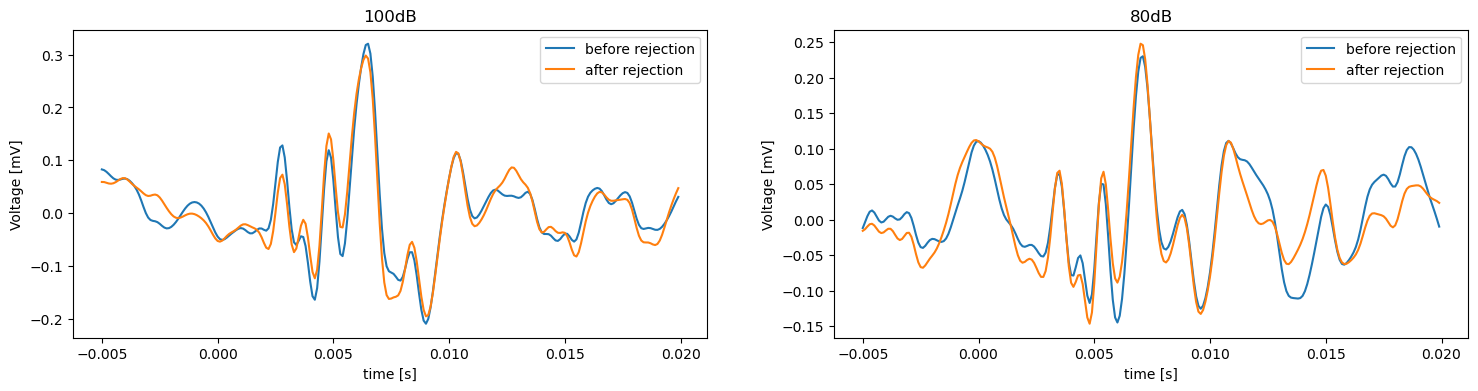

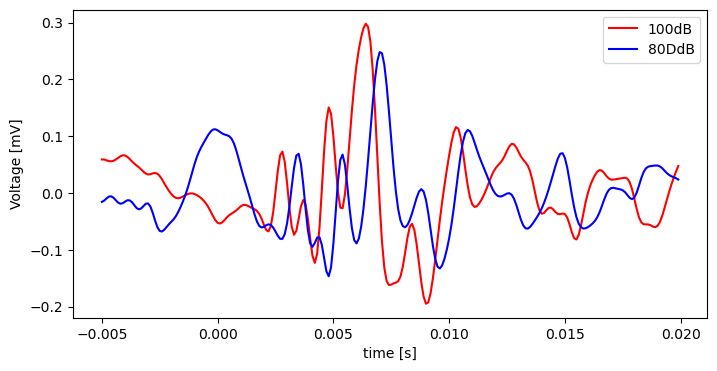

In [10]:
# Compare the means of epochs before and after rejection
mean_100 = np.mean(epochs100,axis=0)
mean_rem_100 = np.mean(removed_epochs100,axis = 0)

mean_80 = np.mean(epochs80,axis=0)
mean_rem_80 = np.mean(removed_epochs80,axis = 0)

fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(121)
plt.plot(t,mean_100)
plt.plot(t,mean_rem_100)
plt.title("100dB")
plt.xlabel("time [s]")
plt.ylabel("Voltage [mV]")
plt.legend(["before rejection", "after rejection"])

ax = fig.add_subplot(122)
plt.plot(t,mean_80)
plt.plot(t,mean_rem_80)
plt.title("80dB")
plt.xlabel("time [s]")
plt.ylabel("Voltage [mV]")
plt.legend(["before rejection", "after rejection"])
plt.show()

fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(121)
plt.plot(t,mean_rem_100,color = "r")
plt.plot(t,mean_rem_80,color = "b")
plt.xlabel("time [s]")
plt.ylabel("Voltage [mV]")
plt.legend(["100dB", "80DdB"])
plt.show()

<div class="alert alert-info">

**Task**
    
* Use the matrix with epochs (after artifact-rejection) to generate a 2.5th and 97.5th percentile waveform of the 80 or 100 dB ABR. The specific steps include, (i) calculate and store 500 resampled mean waveforms from the epoch matrix, by randomly sampling the epoch total (with replacement) from the matrix before you calculate the mean waveform (use `np.random.choice`). After this procedure, you have 500 mean resampled waveforms over time stored. 

* Plot your matrix with 500 mean ABR waveforms (use `yourmatrixname.T` in case there is a dimension mismatch with your time vector), to see that most mean ABR waveforms preserve the ABR waveform maximum near 5 ms.  
    
* Next, you can calculate the CI025 and CI975 waveforms out of the (500 x time) matrix with resampled mean signals. To do this (see also Module 6), you need to write a for loop that has an equal duration as your time vector (`for n in range(0,len(time)):`), and that for each sample, ranks the values from low to high. You can store the indices of ranked values using the `np.argsort` function. Once you did this, you have the indices corresponding to ascending order values for each time sample. Take the index numbers for each time-sample that correspond to the 2.5 and 97.5\%, respectively to generate the CI025 and CI975 waveforms.
    
* For the 80 and 100 dB waveforms, plot the mean waveform (before bootstrapping) along with the waveforms of the confidence bounds on the same plot (with different colors for the 80 and 100 dB condition). You can also modify the following script to plot the confidence interval as a filled area around the mean waveform (but then it is graphically better to plot the results on two figures instead). 
    - plt.show()
    - fig, ax = plt.subplots(1,1,sharex=True)
    - ax.plot(t,xmean,color='k')
    - ax.fill_between(t, CI025[:,0], CI975[:,0],color='C1')
    - plt.show()    

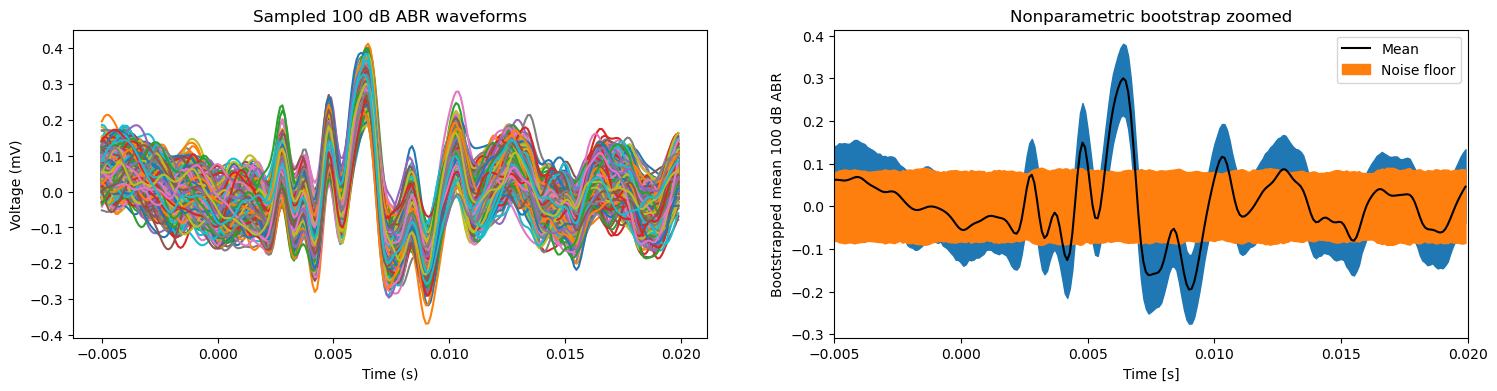

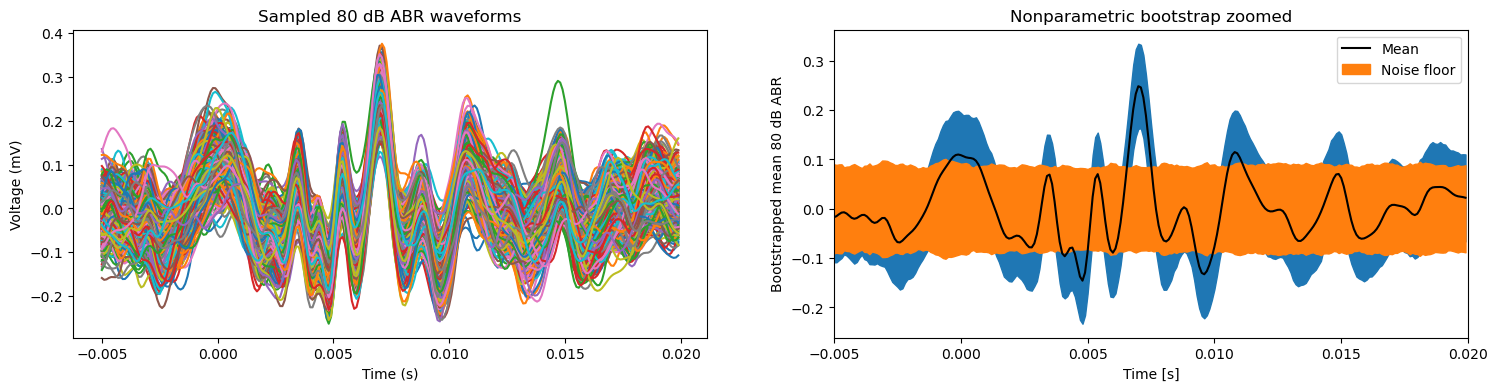

In [19]:
#Your code goes here
# removed_epochs100
# removed_epochs80

#100dB
sample_100 = np.ones((500,len(t)))
num = len(removed_epochs100)
for i in range(500):
    random_100 = np.random.choice(num, num, replace=True)
    samples100 = np.ones((num, len(t)))
    for j, e in enumerate(random_100):
        samples100[j, :] = removed_epochs100[e, :]
    sample_100[i, :] = np.mean(samples100, axis = 0)
        
CI_25, CI_95 = [], []
for i in range(len(t)):
    sorted_indices = np.argsort(sample_100[:, i])
    CI_25.append(sample_100[sorted_indices[int(0.025*500)], i])
    CI_95.append(sample_100[sorted_indices[int(0.975*500)], i])
CI_25, CI_95 = np.array(CI_25), np.array(CI_95)
Noise_floor = (CI_95-CI_25)/2

fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(121)
# plt.plot(t,sample_100.T)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Sampled 100 dB ABR waveforms')
for i in range(len(sample_100)):
    plt.plot(t,sample_100[i])

ax = fig.add_subplot(122)
ax.plot(t, np.mean(sample_100, axis = 0), 'k', label = 'Mean')
ax.fill_between(t, CI_95, CI_25, color='C0')
ax.fill_between(t, Noise_floor, - Noise_floor, color = 'C1', label ='Noise floor')
ax.legend()
ax.set_ylabel('Bootstrapped mean 100 dB ABR')
ax.set_xlabel('Time [s]')
ax.set_title('Nonparametric bootstrap zoomed' )
plt.xlim(-0.005, 0.020)
plt.show()

#80dB
sample_80 = np.ones((500,len(t)))
num = len(removed_epochs80)
for i in range(500):
    random_80 = np.random.choice(num, num, replace=True)
    samples80 = np.ones((num, len(t)))
    for j, e in enumerate(random_80):
        samples80[j, :] = removed_epochs80[e, :]
    sample_80[i, :] = np.mean(samples80, axis = 0)
        
CI_25, CI_95 = [], []
for i in range(len(t)):
    sorted_indices = np.argsort(sample_80[:, i])
    CI_25.append(sample_80[sorted_indices[int(0.025*500)], i])
    CI_95.append(sample_80[sorted_indices[int(0.975*500)], i])
CI_25, CI_95 = np.array(CI_25), np.array(CI_95)
Noise_floor = (CI_95-CI_25)/2

fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(121)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Sampled 80 dB ABR waveforms')
for i in range(len(sample_80)):
    plt.plot(t,sample_80[i])

ax = fig.add_subplot(122)
ax.plot(t, np.mean(sample_80, axis = 0), 'k', label = 'Mean')
ax.fill_between(t, CI_95, CI_25, color='C0')
ax.fill_between(t, Noise_floor, - Noise_floor, color = 'C1', label ='Noise floor')
ax.legend()
ax.set_ylabel('Bootstrapped mean 80 dB ABR')
ax.set_xlabel('Time [s]')
ax.set_title('Nonparametric bootstrap zoomed' )
plt.xlim(-0.005, 0.020)
plt.show()

<div class="alert alert-info">

**Task**

Now that we have calculated the confidence intervals on the two ABR waveforms, we are ready to perform the statistics to address our research questions:
* Is the wave-V peak amplitude significantly higher for an ABR to a 100 dB stimulus than for the ABR to a 80 dB stimulus level?
* Is the wave-V latency (i.e. the time [in ms] at which the peak of wave-V occurs) significantly shorter for the 100 dB stimulus than for the 80 dB stimulus?

To transform the samples of your epoch into latency, please note that you can use FS to go from sample number to the time domain, and that the onset of the stimulus corresponds to time 0, knowing that you started your epoch at -5 ms. Also convenient for your analysis is to know that the ABR wave-V peak corresponds to the maximum of the signal, hence it should be easy to calculate the wave-V response peak in a for-loop.
    
* To address the wave-V peak question: first identify for the 80 and 100 dB signal, which sample number you want to consider for each response (i.e. the sample at which the wave-V maximum occurs in the mean ABR response). Then generate a normal sample of ABR wave-V maxima from your stored 500 resampled mean waveforms. Plot the histograms of your 500 wave-V amplitude draws for the 80 and 100 dB waveforms. Do they visually overlap? Perform a z or t-test to asses significance of your result. What is the zero-hypothesis for your test, and interpret the test outcome?
    
* To address the latency question: in a for loop, find the index which corresponds to the maximum of each of the 500 resampled mean waveforms. You can then calculate a normal distribution of ABR wave-V latencies for each of the 80 dB and 100 dB waveforms. Plot a histogram of your latency estimate distributions and perform a t-test or z-test to formulate an answer to your research question.       

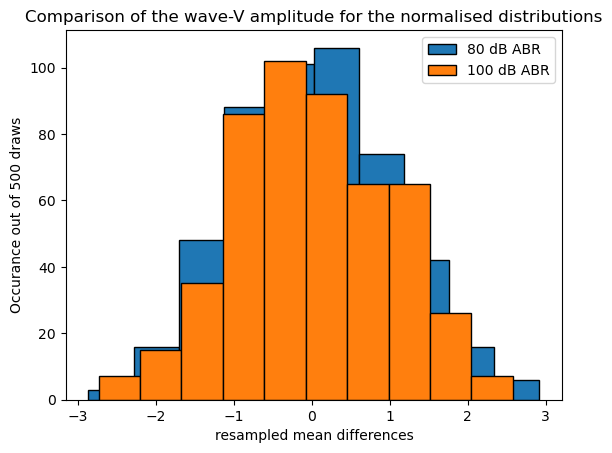

t-test: H0: Is the amplitude of the wave-V peak for an ABR to 100 dB the same as for an ABR to 80 dB
H1: amplitude 100 dB > amplitude 80 dB
to reject the hypothesis: p < 0.05 (single-sided test)
Ttest_indResult(statistic=1.3383936470195289e-14, pvalue=0.9999999999999893)


In [25]:
#Your code goes here
#wave-V peak
##100 dB
sample_number100 = []
wave_Vmax100 = []
for i in range(len(sample_100)):
    sample_number100.append(np.argmax(sample_100[i]))
    wave_Vmax100.append(np.max(sample_100[i]))
    
Vmax100_normalised = []
for i in range(len(wave_Vmax100)):
    Vmax100_normalised.append((wave_Vmax100[i] - np.mean(wave_Vmax100))/np.std(wave_Vmax100))

##80 dB
sample_number80 = []
wave_Vmax80 = []
for i in range(len(sample_80)):
    sample_number80.append(np.argmax(sample_80[i]))
    wave_Vmax80.append(np.max(sample_80[i]))
    
Vmax80_normalised = []
for i in range(len(wave_Vmax80)):
    Vmax80_normalised.append((wave_Vmax80[i] - np.mean(wave_Vmax80))/np.std(wave_Vmax80))

plt.hist(Vmax80_normalised, edgecolor = 'k', label = '80 dB ABR')
plt.hist(Vmax100_normalised, edgecolor = 'k', label = '100 dB ABR')
plt.title('Comparison of the wave-V amplitude for the normalised distributions')
plt.xlabel('resampled mean differences')
plt.ylabel('Occurance out of 500 draws')
plt.legend()
plt.show()

# The shape of the graph changes in response to the random value

print("t-test: H0: Is the amplitude of the wave-V peak for an ABR to 100 dB the same as for an ABR to 80 dB")
print("H1: amplitude 100 dB > amplitude 80 dB")
print("to reject the hypothesis: p < 0.05 (single-sided test)")
    
print(scipy.stats.ttest_ind(Vmax100_normalised, Vmax80_normalised))


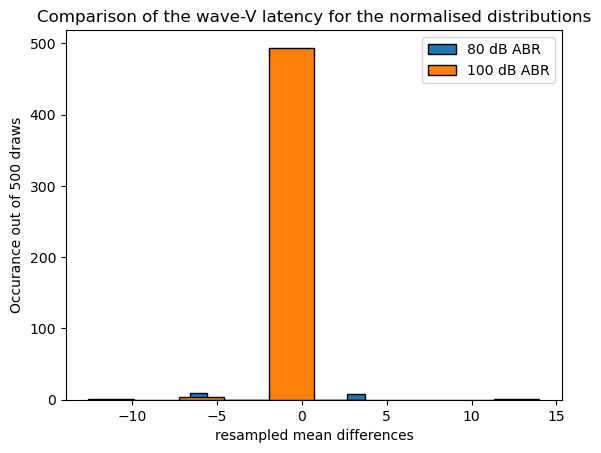

t-test: H0: Is the latency of the wave-V peak for an ABR to 100 dB the same as for an ABR to 80 dB
H1: latency 100 dB < latency 80 dB
to reject the hypothesis: p < 0.05 (single-sided test)
Ttest_indResult(statistic=6.212166738996304e-14, pvalue=0.9999999999999505)


In [26]:
wave_Vmax100_time = np.array(sample_number100)/FS/2
wave_Vmax80_time = np.array(sample_number80)/FS/2

Vmax100_time_normalised = []
for i in range(len(wave_Vmax100_time)):
    Vmax100_time_normalised.append((wave_Vmax100_time[i] - np.mean(wave_Vmax100_time))/np.std(wave_Vmax100_time))
    
Vmax80_time_normalised = []
for i in range(len(wave_Vmax80_time)):
    Vmax80_time_normalised.append((wave_Vmax80_time[i] - np.mean(wave_Vmax80_time))/np.std(wave_Vmax80_time))
    
plt.hist(Vmax80_time_normalised, edgecolor = 'k', label = '80 dB ABR')
plt.hist(Vmax100_time_normalised, edgecolor = 'k', label = '100 dB ABR')
plt.title('Comparison of the wave-V latency for the normalised distributions')
plt.xlabel('resampled mean differences')
plt.ylabel('Occurance out of 500 draws')
plt.legend()
plt.show()

print("t-test: H0: Is the latency of the wave-V peak for an ABR to 100 dB the same as for an ABR to 80 dB")
print("H1: latency 100 dB < latency 80 dB")
print("to reject the hypothesis: p < 0.05 (single-sided test)")
    
print(scipy.stats.ttest_ind(Vmax100_time_normalised, Vmax80_time_normalised))